In [53]:
# Full implementation of the modified Iterated Greedy Algorithm including modified_local_search

import copy
import random
import math

def evaluate(battery_swap_schedule):
    total_travel_time = 0
    total_waiting_time = 0
    battery_urgency_score = 0
    active_fleet_batery_score = 0
    total_battery_cycle = 0
    # for i in range(len(battery_swap_schedule)):
    #     if battery_swap_schedule[i]["assigned"]:
    #         total_travel_time += battery_swap_schedule[i]["travel_time"]
    #         total_waiting_time += battery_swap_schedule[i]["waiting_time"]
    #         battery_urgency_score += ((100 - battery_swap_schedule[i]["exchanged_battery"]) ** 2)
    #         active_fleet_batery_score += (battery_swap_schedule[i]["received_battery"] ** 2)
    #     else:
    #         active_fleet_batery_score += battery_swap_schedule[i]["battery_now"]
    for ev_id, sched in battery_swap_schedule.items():
        if sched and sched.get("assigned"):
            total_travel_time += sched["travel_time"]
            total_waiting_time += sched["waiting_time"]
            battery_urgency_score += ((100 - sched["exchanged_battery"]) ** 2)
            active_fleet_batery_score += (sched["received_battery"] ** 2)
            total_battery_cycle += sched["received_battery_cycle"]
        elif sched:
            active_fleet_batery_score += sched["battery_now"]
    if total_travel_time or total_waiting_time:
        total_score = (battery_urgency_score + active_fleet_batery_score) / ((total_travel_time + (10 * total_waiting_time))/60 + total_battery_cycle/8)
    else:
        total_score = battery_urgency_score + active_fleet_batery_score

    return total_score

def queue_update(solution, ev, battery_swap_station, charging_rate, required_battery_threshold=80):
    slot_timeline = {}
    station_batteries = copy.deepcopy(battery_swap_station)

    swaps = []

    # 1. Masukkan jadwal tetap (dari ev['swap_schedule']) dulu ke slot_timeline
    # Kumpulkan semua jadwal tetap dari ev['swap_schedule']
    temp_queue = {}

    for ev_id, data in ev.items():
        sched = copy.deepcopy(data.get('swap_schedule'))
        if sched and sched.get('assigned'):
            key = (sched['battery_station'], sched['slot'])
            ready_time = sched['travel_time'] + sched['waiting_time']
            exchanged_battery = sched['exchanged_battery']
            exchanged_battery_cycle = sched['battery_cycle']

            if key not in temp_queue:
                temp_queue[key] = [(ready_time, exchanged_battery, exchanged_battery_cycle)]
            else:
                temp_queue[key].append((ready_time, exchanged_battery, exchanged_battery_cycle))

    # Urutkan setiap antrian berdasarkan arrival_time
    slot_timeline = {
        key: sorted(entries, key=lambda x: x[0])
        for key, entries in temp_queue.items()
    }

    # 2. Kumpulkan EV dari solusi yang assigned, tapi hanya yang tidak punya jadwal tetap
    for ev_id, sched in solution.items():
        if sched['assigned'] and not ev[ev_id]['swap_schedule']:
            arrival_time = sched['travel_time']
            key = (sched['battery_station'], sched['slot'])
            swaps.append((arrival_time, ev_id, key))

    # 3. Urutkan berdasarkan arrival_time (yang datang duluan diproses lebih dulu)
    swaps.sort()

    # 4. Proses masing-masing EV, hitung ulang waiting_time dan received_battery
    for _, ev_id, key in swaps:
        sched = solution[ev_id]
        station_idx, slot_idx = key

        if key not in slot_timeline:
            last_ready_time = 0
            last_insert = battery_swap_station[station_idx][slot_idx][0]
            last_insert_cycle = battery_swap_station[station_idx][slot_idx][1]
        else:
            last_ready_time, last_insert, last_insert_cycle = slot_timeline[key][-1]

        arrival_time = sched['travel_time']
        time_to_80 = max(0, (required_battery_threshold - last_insert) / charging_rate)
        ready_time = last_ready_time + time_to_80
        waiting_time = max(0, ready_time - arrival_time)

        exchanged_battery = sched['exchanged_battery']
        received_battery = min(100, last_insert + (arrival_time + waiting_time - last_ready_time) * charging_rate)
        exchanged_battery_cycle = sched['battery_cycle']
        received_battery_cycle = last_insert_cycle + (received_battery - last_insert) / 100

        # Update ke dalam solution
        solution[ev_id]['waiting_time'] = round(waiting_time, 2)
        solution[ev_id]['received_battery'] = round(received_battery, 2)
        solution[ev_id]['received_battery_cycle'] = round(received_battery_cycle, 2)

        # Tambahkan ke slot_timeline untuk update antrian selanjutnya
        if key not in slot_timeline:
            slot_timeline[key] = [(arrival_time + waiting_time, exchanged_battery, exchanged_battery_cycle)]
        else:
            slot_timeline[key].append((arrival_time + waiting_time, exchanged_battery, exchanged_battery_cycle))

    return solution

def random_initialization(battery_swap_station, ev, threshold, charging_rate, required_battery_threshold=80):
    solution = {}
    station_batteries = copy.deepcopy(battery_swap_station)

    # Inisialisasi semua EV yang punya schedule tetap
    for i, data in ev.items():
        if data['swap_schedule']:
            solution[i] = copy.deepcopy(data['swap_schedule'])

    # Ambil EV yang layak dijadwalkan
    candidates = []
    for i, data in ev.items():
        if data['swap_schedule']:
            continue
        energy_to_nearest = min(data['energy_distance'])
        if data['battery_now'] - energy_to_nearest < threshold:
            candidates.append(i)

    # Acak urutan EV
    random.shuffle(candidates)

    # Jadwalkan secara acak ke slot kosong
    slot_keys = [(i, j) for i in range(len(battery_swap_station)) for j in range(len(battery_swap_station[i]))]
    slot_usage = {k: [] for k in slot_keys}

    for i in candidates:
        data = ev[i]
        valid_options = []

        for station_idx, (ed, tt) in enumerate(zip(data['energy_distance'], data['travel_time'])):
            if data['battery_now'] - ed < 0:
                continue
            for slot_idx in range(len(battery_swap_station[station_idx])):
                valid_options.append((station_idx, slot_idx, ed, tt))

        if not valid_options:
            solution[i] = {
                'assigned': False,
                'battery_now': data['battery_now'],
                'battery_cycle': data['battery_cycle'],
                'battery_station': None,
                'slot': None,
                'energy_distance': None,
                'travel_time': None,
                'waiting_time': None,
                'exchanged_battery': None,
                'received_battery': None,
                'received_battery_cycle': None
            }
            continue

        # Pilih slot acak dari opsi valid
        station_idx, slot_idx, energy_dist, travel_time = random.choice(valid_options)
        key = (station_idx, slot_idx)
        exchanged_battery = data['battery_now'] - energy_dist

        solution[i] = {
            'assigned': True,
            'battery_now': data['battery_now'],
            'battery_cycle': data['battery_cycle'],
            'battery_station': station_idx,
            'slot': slot_idx,
            'energy_distance': energy_dist,
            'travel_time': travel_time,
            'waiting_time': 0,  # akan diupdate
            'exchanged_battery': exchanged_battery,
            'received_battery': 0,  # akan diupdate
            'received_battery_cycle': 0 # akan diupdate
        }

    # Update ulang waiting_time dan received_battery
    solution = queue_update(solution, ev, battery_swap_station, charging_rate, required_battery_threshold)
    return solution

def selective_destroy(solution, ev, destroy_ratio=0.1):
    new_solution = copy.deepcopy(solution)
    assigned_ids = [
        ev_id for ev_id, sched in solution.items()
        if sched.get("assigned") and not ev[ev_id].get("swap_schedule")
    ]
    to_modify = random.sample(assigned_ids, max(1, int(len(assigned_ids) * destroy_ratio)))

    for ev_id in to_modify:
        sched = new_solution[ev_id]
        sched["battery_station"] = None
        sched["slot"] = None
        sched["energy_distance"] = None
        sched["travel_time"] = None
        sched["waiting_time"] = None
        sched["exchanged_battery"] = None
        sched["received_battery"] = None
        sched["received_battery_cycle"] = None

    return new_solution, to_modify

def selective_repair(solution, ev, battery_swap_station, to_repair):
    new_solution = copy.deepcopy(solution)

    for ev_id in to_repair:
        data = ev[ev_id]
        valid_options = []
        for station_idx, (ed, tt) in enumerate(zip(data['energy_distance'], data['travel_time'])):
            if data['battery_now'] - ed < 0:
                continue
            for slot_idx in range(len(battery_swap_station[station_idx])):
                exchanged_battery = data['battery_now'] - ed
                score = -tt + (exchanged_battery / 10)  # contoh skor sederhana
                valid_options.append((score, station_idx, slot_idx, ed, tt))
        if valid_options:
            _, station_idx, slot_idx, ed, tt = max(valid_options, key=lambda x: x[0])
            exchanged_battery = data['battery_now'] - ed
            new_solution[ev_id] = {
                'assigned': True,
                'battery_now': data['battery_now'],
                'battery_cycle': data['battery_cycle'],
                'battery_station': station_idx,
                'slot': slot_idx,
                'energy_distance': ed,
                'travel_time': tt,
                'waiting_time': 0,
                'exchanged_battery': exchanged_battery,
                'received_battery': 0,
                'received_battery_cycle': 0
            }

    return new_solution

def modified_local_search(solution, ev, battery_swap_station, charging_rate, required_battery_threshold):
    neighbor = copy.deepcopy(solution)
    candidates = [
        ev_id for ev_id, sched in neighbor.items()
        if sched.get("assigned") and not ev[ev_id].get("swap_schedule")
    ]
    if not candidates:
        return neighbor

    weighted_candidates = []
    for ev_id in candidates:
        if neighbor[ev_id]['waiting_time'] > 0:
            weighted_candidates.extend([ev_id]*6)
        else:
            weighted_candidates.extend([ev_id]*4)
    target_ev = random.choice(weighted_candidates)
    data = ev[target_ev]

    valid_options = []
    for station_idx, (ed, tt) in enumerate(zip(data['energy_distance'], data['travel_time'])):
        if data['battery_now'] - ed < 0:
            continue
        for slot_idx in range(len(battery_swap_station[station_idx])):
            valid_options.append((station_idx, slot_idx, ed, tt))
    if valid_options:
        station_idx, slot_idx, ed, tt = random.choice(valid_options)
        exchanged_battery = data['battery_now'] - ed
        neighbor[target_ev] = {
            'assigned': True,
            'battery_now': data['battery_now'],
            'battery_cycle': data['battery_cycle'],
            'battery_station': station_idx,
            'slot': slot_idx,
            'energy_distance': ed,
            'travel_time': tt,
            'waiting_time': 0,
            'exchanged_battery': exchanged_battery,
            'received_battery': 0,
            'received_battery_cycle': 0
        }
    return queue_update(neighbor, ev, battery_swap_station, charging_rate, required_battery_threshold)

def iterated_greedy_ev_modified(
    battery_swap_station,
    ev,
    threshold,
    charging_rate,
    required_battery_threshold=80,
    max_iter=1000
):
    S = random_initialization(battery_swap_station, ev, threshold, charging_rate, required_battery_threshold)
    best = copy.deepcopy(S)
    best_score = evaluate(S)
    T = 1.0

    for _ in range(max_iter):
        # destroyed, modified_ids = selective_destroy(S, ev, destroy_ratio=0.1)
        # reconstructed = selective_repair(destroyed, ev, battery_swap_station, modified_ids)
        reconstructed = modified_local_search(S, ev, battery_swap_station, charging_rate, required_battery_threshold)

        score = evaluate(reconstructed)
        delta = score - evaluate(S)

        if delta > 0 or random.random() < math.exp(delta / (T + 1e-6)):
            S = reconstructed
            if score > best_score:
                best = copy.deepcopy(S)
                best_score = score

        T *= 0.95
        print(best_score)

    return best, best_score


In [54]:
import pickle

# Load dataset pickle
with open("ev_battery_swap_random_dataset.pkl", "rb") as f:
    battery_swap_station_demo, ev_demo = pickle.load(f)

# Jalankan algoritma iterated greedy yang sudah dimodifikasi
solution, fitness = iterated_greedy_ev_modified(
    battery_swap_station=battery_swap_station_demo,
    ev=ev_demo,
    threshold=15,
    charging_rate=100 / 240,
    required_battery_threshold=80,
    max_iter=100  # atau ganti sesuai kebutuhanmu
)


173.94216783052096
173.94216783052096
173.94216783052096
176.34902219645437
178.77494244628357
178.77494244628357
178.77494244628357
179.9530574350321
179.9530574350321
179.9530574350321
180.513869249359
181.26095170919712
181.613574283899
181.613574283899
181.613574283899
181.77897996356242
181.77897996356242
181.77897996356242
181.77897996356242
182.40568780201053
182.40568780201053
182.40568780201053
182.66300375481197
182.66300375481197
183.64331632986202
183.64331632986202
183.64331632986202
183.64331632986202
183.64331632986202
183.64331632986202
184.35779718098883
184.35779718098883
184.35779718098883
184.35779718098883
184.35779718098883
184.35779718098883
184.35779718098883
184.35779718098883
188.02623192048736
188.02623192048736
188.02623192048736
188.02623192048736
188.93810176970234
188.93810176970234
188.93810176970234
188.93810176970234
188.93810176970234
189.16764433263427
189.16764433263427
191.65596304213892
191.65596304213892
191.65596304213892
191.65596304213892
191.

In [55]:
import time
import numpy as np
import matplotlib.pyplot as plt


def plot_distributions_2(initial_temp=100, num_of_cycle=100, runs=1000, max_attempts=1000):
    """
    Run the Simulated Annealing algorithm multiple times and plot distributions of 
    both fitness values and computation times.
    
    Parameters:
    - initial_temp: Initial temperature
    - num_of_cycle: Number of cycles after which temperature becomes 0
    - runs: Number of independent runs
    - max_attempts: Maximum number of attempts to find a valid solution
    
    Returns:
    - mean_fitness: Mean fitness across all valid runs
    - std_fitness: Standard deviation of fitness across all valid runs
    - mean_duration: Mean computation time across all runs (in seconds)
    - std_duration: Standard deviation of computation time across all runs (in seconds)
    """
    fitness_values = []
    duration_values = []
    valid_runs = 0
    
    print(f"Running {runs} trials of improved GWO...")
    
    for i in range(runs):
        if i % 100 == 0 and i > 0:
            print(f"Completed {i} runs...")
            
        start_time = time.time()
        
        solution, fitness = iterated_greedy_ev_modified(
            battery_swap_station=battery_swap_station_demo,
            ev=ev_demo,
            threshold=15,
            charging_rate=100 / 240,
            required_battery_threshold=80,
            max_iter=200  # atau ganti sesuai kebutuhanmu
        )
                
        end_time = time.time()
        duration = end_time - start_time
        duration_values.append(duration)
        
        if solution is not None and fitness is not None:
            fitness_values.append(fitness)
            valid_runs += 1
    
    # Print summary
    print(f"Valid solutions: {valid_runs}/{runs} ({valid_runs/runs*100:.2f}%)")
    
    # 1. PLOT FITNESS DISTRIBUTION
    if fitness_values:
        # Calculate fitness statistics
        mean_fitness = np.mean(fitness_values)
        std_fitness = np.std(fitness_values)
        
        # Plot fitness distribution
        plt.figure(figsize=(8, 6))
        plt.hist(fitness_values, bins=20, edgecolor='black')
        plt.axvline(mean_fitness, linestyle='--', label=f'Mean = {mean_fitness:.2f}')
        plt.axvline(mean_fitness + std_fitness, color='gray', linestyle=':', 
                    label=f'+1 Std = {std_fitness:.2f}')
        plt.axvline(mean_fitness - std_fitness, color='gray', linestyle=':', 
                    label=f'-1 Std = {std_fitness:.2f}')
        plt.title('Distribution of Best Fitness over {} Runs'.format(valid_runs))
        plt.xlabel('Fitness')
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print(f"Mean fitness: {mean_fitness:.4f}")
        print(f"Std deviation of fitness: {std_fitness:.4f}")
    else:
        mean_fitness = None
        std_fitness = None
        print("No valid solutions found to plot fitness distribution")
    
    # 2. PLOT DURATION DISTRIBUTION
    if duration_values:
        # Calculate duration statistics
        mean_duration = np.mean(duration_values)
        std_duration = np.std(duration_values)
        
        # Plot duration distribution
        plt.figure(figsize=(8, 6))
        plt.hist(duration_values, bins=20, edgecolor='black')
        plt.axvline(mean_duration, linestyle='--', label=f'Mean = {mean_duration:.4f}s')
        plt.axvline(mean_duration + std_duration, color='gray', linestyle=':', 
                    label=f'+1 Std = {std_duration:.4f}s')
        plt.axvline(mean_duration - std_duration, color='gray', linestyle=':', 
                    label=f'-1 Std = {std_duration:.4f}s')
        plt.title('Distribution of Computation Time over {} Runs'.format(runs))
        plt.xlabel('Time (seconds)')
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print(f"Mean computation time: {mean_duration:.4f} seconds")
        print(f"Std deviation of time: {std_duration:.4f} seconds")
    else:
        mean_duration = None
        std_duration = None
        print("No runs completed to plot duration distribution")
    
    return mean_fitness, std_fitness, mean_duration, std_duration


Running 100 trials of improved GWO...
161.08185555883202
161.08185555883202
164.31741206681767
164.31741206681767
164.31741206681767
164.73419565031378
164.73419565031378
164.73419565031378
164.73419565031378
164.73419565031378
164.73419565031378
164.73419565031378
164.73419565031378
164.73419565031378
165.8718481619716
165.8718481619716
165.8718481619716
165.8718481619716
166.1985782301893
167.92352385909678
167.92352385909678
167.92352385909678
167.92352385909678
167.92352385909678
170.0116302688138
172.70463270522225
173.2787149364001
173.2787149364001
173.2787149364001
173.2787149364001
175.69893542627625
175.69893542627625
176.61281624472488
176.61281624472488
176.61281624472488
179.34044158040876
180.81496232048562
182.4301553635085
182.4301553635085
182.4301553635085
182.4301553635085
184.50607526419722
185.13313455779019
185.13313455779019
185.5634894435527
185.5634894435527
185.5634894435527
185.5634894435527
185.5634894435527
185.5634894435527
185.68616246545267
185.686162465

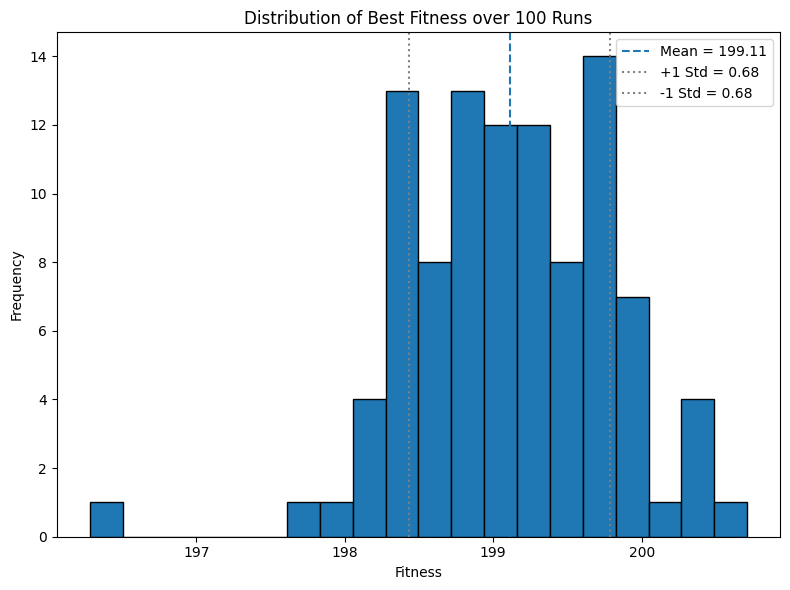

Mean fitness: 199.1108
Std deviation of fitness: 0.6772


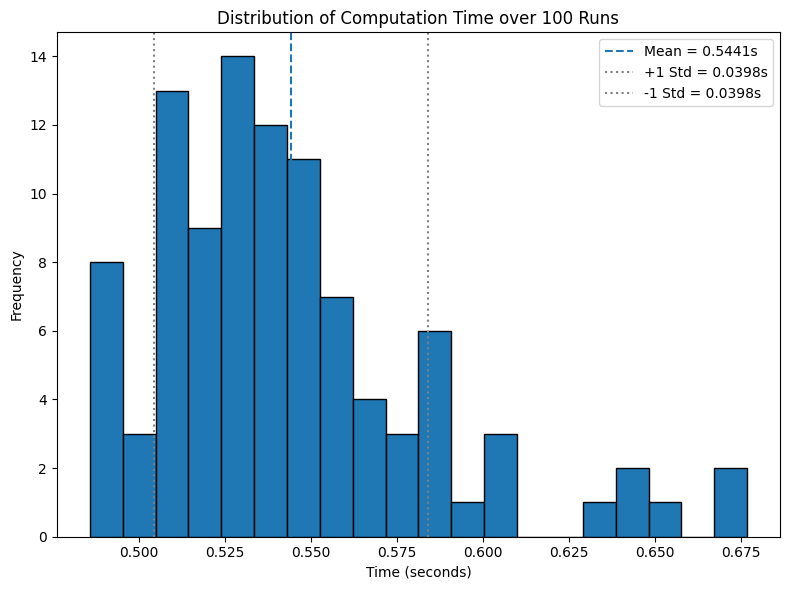

Mean computation time: 0.5441 seconds
Std deviation of time: 0.0398 seconds


(np.float64(199.11077934176592),
 np.float64(0.6771687618723365),
 np.float64(0.5440610790252686),
 np.float64(0.03979707244296806))

In [56]:
plot_distributions_2(initial_temp=100, num_of_cycle=300, runs=100, max_attempts=10)